In [ ]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [ ]:
!pip install transformers sentencepiece sacrebleu datasets  sentence-transformers fasttext -q

     |████████████████████████████████| 4.7 MB 30.3 MB/s 
     |████████████████████████████████| 1.2 MB 59.5 MB/s 
     |████████████████████████████████| 116 kB 75.8 MB/s 
     |████████████████████████████████| 365 kB 64.0 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 68 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.9 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 141 kB 75.1 MB/s 
     |████████████████████████████████| 212 kB 69.3 MB/s 
     |████████████████████████████████| 127 kB 78.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

## Prepare data and tokenizers

In [ ]:
!ls /gd/MyDrive/models/myv/

lid.323.ftz		   mbart-large-51-myv-raw    mul_translation_v1.tsv
mbart-large-51-mul-myv-v1  mbart-large-51-myv-ru-v1  mul_translation_v2.tsv
mbart-large-51-myv-mul-v1  mbart-large-51-ru-myv-v1  mul_translation_v3.tsv


In [ ]:
BASE_DIR = '/gd/MyDrive/models/myv/'

In [ ]:
base_model_path = '/gd/MyDrive/models/myv/mbart-large-51-myv-raw'

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [ ]:
old_len = len(tokenizer)
old_len

269545

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
tokenizer.lang_code_to_id['myv_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'myv_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'myv_XX' not in tokenizer._additional_special_tokens:
    tokenizer._additional_special_tokens.append('myv_XX')

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/train.v1.json', 'r') as f:
    golden_pairs = json.load(f)
print(len(golden_pairs))

74503


In [ ]:
random.choice(golden_pairs)

['озамс', 'приземлиться']

In [ ]:
golden_sents = [[t1, t2] for t1, t2 in golden_pairs if len(t1.split()) > 1 and len(t2.split()) > 1]
len(golden_sents)

34798

In [ ]:
random.choice(golden_sents)

['Ды мерсь крандазонть лоткавтомадо. Филип ды евнухось совасть ведьс, ды Филип нававтызе сонзэ.',
 'И приказал остановить колесницу, и сошли оба в воду, Филипп и евнух; и крестил его.']

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'r') as f:
    back_translated = json.load(f)
silver_pairs = list(zip(back_translated['original'], back_translated['translated']))
print(len(silver_pairs))

333651


In [ ]:
random.choice(silver_pairs)

('лоткавкс', 'остановка')

In [ ]:
all_pairs = golden_pairs + silver_pairs
print(len(all_pairs))

408154


In [ ]:
myv_texts = [myv for myv, ru in all_pairs]

### Multilanguage data

In [ ]:
from sentence_transformers import SentenceTransformer
sim_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2', device='cpu')

In [ ]:
def embed(text):
    e = sim_model.encode([text])[0]
    e /= sum(e**2)**0.5
    return e

In [ ]:
def is_good_pair(text1, text2, threshold=0.6, extra_chars=10, min_len_ratio=0.5):
    """ Test whether two texts are possibly translations of each other. Thresholds are picked manually. """
    len1, len2 = len(text1), len(text2)
    len_ratio = (min(len1, len2) + extra_chars) / (max(len1, len2) + extra_chars)
    if len_ratio < min_len_ratio:
        return False  # early return to speed up comparison
    emb_sim = np.dot(embed(text1), embed(text2))
    return emb_sim >= threshold

In [ ]:
from datasets import load_dataset

In [ ]:
LANGS2 = [
    'fi', 'de', 'es', 'en', 'hi', 'zh', 
     'tr', # Turkish data seems to be broken
    #'kk', 
    'uk', 'fr', 'ar'
]
LANGS2to3 = {
    'fi': 'fi_FI', 
    'de': 'de_DE', 
    'es': 'es_XX', 
    'en': 'en_XX', 
    'hi': 'hi_IN',
    'zh': 'zh_CN', 
    'tr': 'tr_TR',
    #'kk': 'kk_KZ',
    'uk': 'uk_UA', 
    'fr': 'fr_XX', 
    'ar': 'ar_AR',
}
for v in LANGS2to3.values():
    assert v in tokenizer.additional_special_tokens
len(LANGS2)

10

In [ ]:
streaming_datasets = {
    lang: load_dataset("yhavinga/ccmatrix", lang1="ru", lang2=lang, streaming=True)
    for lang in LANGS2
}

Using custom data configuration ru-fi-lang1=ru,lang2=fi
Using custom data configuration ru-de-lang1=ru,lang2=de
Using custom data configuration ru-es-lang1=ru,lang2=es
Using custom data configuration ru-en-lang1=ru,lang2=en
Using custom data configuration ru-hi-lang1=ru,lang2=hi
Using custom data configuration ru-zh-lang1=ru,lang2=zh
Using custom data configuration ru-tr-lang1=ru,lang2=tr
Using custom data configuration ru-uk-lang1=ru,lang2=uk
Using custom data configuration ru-fr-lang1=ru,lang2=fr
Using custom data configuration ru-ar-lang1=ru,lang2=ar


In [ ]:
streaming_iterators = {k: iter(v['train']) for k, v in streaming_datasets.items()}

In [ ]:
def get_item(lang):
    try:
        return next(streaming_iterators[lang])
    except StopIteration:
        streaming_iterators[lang] = iter(streaming_datasets[lang]['train'])
        return next(streaming_iterators[lang])

**VALIDATE ALL THE SOURCES, BECAUSE SOME SEEM TO BE VERY BAD**

In [ ]:
def get_good_item(lang):
    try:
        for _ in range(10000):
            item = next(streaming_iterators[lang])
            texts = list(item['translation'].values())
            if is_good_pair(*texts):
                return item 
    except StopIteration:
        streaming_iterators[lang] = iter(streaming_datasets[lang]['train'])
        return next(streaming_iterators[lang])

In [ ]:
for lang in streaming_iterators:
    item = get_item(lang)
    print(lang)
    print(item['translation']['ru'])
    print(item['translation'][lang])
    text1, text2 = item['translation']['ru'], item['translation'][lang]
    len1, len2 = len(text1), len(text2)
    extra_chars = 10
    len_ratio = (min(len1, len2) + extra_chars) / (max(len1, len2) + extra_chars)
    print(np.dot(embed(text1), embed(text2)), len_ratio)

fi
Ибо порицание ваше будет ложным.
Unfaithfully Yours lataa Ilmaiseksi
0.6703366 0.9333333333333333
de
Между нами настоящая стена: с одной стороны – творение, с другой стороны – Творец.
Zwischen uns steht eine richtige Wand: auf der einen Seite die Schöpfung, auf der anderen Seite der Schöpfer.
0.9627032 0.773109243697479
es
26. а только слова: «Мир!
26. sino una palabra: "¡Paz!
0.8183235 0.9210526315789473
en
Почему можно сказать, что ложь Сатаны была злонамеренной, и к чему она привела?
Why can it be said that Satan’s lie was malicious, and what has resulted from it?
0.9701552 0.978021978021978
hi
"Спроси же их: "Разве у твоего Господа дочери, а у них сыновья?"
(148) अब उनसे पूछो, "क्या तुम्हारे रब के लिए तो बेटियाँ हों और उनके अपने लिए बेटे?
0.9023713 0.8043478260869565
zh
б) от них следует отличать внутренних шпионов, которые обладают определенным статусом в стане противника;
（轻）（殊）（还）（兀）（自）（在）（做）（心）（理）（斗）（争）（，）（听）（得）（他）（问）（，）（愣）（了）（愣）（才）（反）（应）（过）（来）（，）（忙）（道）（：）（郁）（瓷）（说）（四）（界）（考）（

In [ ]:
for lang in streaming_iterators:
    item = get_good_item(lang)
    print(lang)
    print(item['translation']['ru'])
    print(item['translation'][lang])
    text1, text2 = item['translation']['ru'], item['translation'][lang]
    len1, len2 = len(text1), len(text2)
    extra_chars = 10
    len_ratio = (min(len1, len2) + extra_chars) / (max(len1, len2) + extra_chars)
    print(np.dot(embed(text1), embed(text2)), len_ratio)

fi
„Но среди них есть такие, которые говорят: „Господь наш!
Heistä (ihmisistä) on joitakin, jotka sanovat: 'Herramme!
0.852143 0.9850746268656716
de
После чего родителям грозит суровое наказание [5].
Und die Eltern mußten mit einer gehörigen Strafe rechnen.
0.8626051 0.8955223880597015
es
Так Я, поистине, прощающ, милосерд!
¡Ciertamente soy Yo el Perdonador, el Misericordioso!
0.78711045 0.7142857142857143
en
Аллах любит творящих добро» (3: 146-148).
God loves the doers of good." (3:146-148).
0.8119905 0.9807692307692307
hi
Она вопрошает: 'Почему Аллах даровал мне такую длинную жизнь и так мало счастья?...
उसने पूछा: ‘अल्लाह ने मुझे इतना लंबा जीवन और इतनी छोटी खुशी क्यों दी?
0.88008314 0.8494623655913979
zh
Практическая (
做法 （
0.66877925 0.5833333333333334
tr
если вы [люди] правдивые.
Eğer doğru sözlü kişilerseniz.
0.9262928 0.875
uk
А у кого они с ним хорошие?» - Коваленко
А у кого вони з ним хороші?»- Коваленко
0.9936614 0.98
fr
Поэтому, если они будут сражаться с израильтянами на ра

Bad pairs: 
* fi?, tr, ar?

In [ ]:
get_item('tr')

{'id': 4,
 'score': 1.2451718,
 'translation': {'ru': 'А стена – часть тебя самого –',
  'tr': 'Valley Center İçindeki En İyi Salata'}}

In [ ]:
get_item('fr')

{'id': 2,
 'score': 1.2442542,
 'translation': {'fr': 'Et Allah voit parfaitement ce que vous faites.266.',
  'ru': 'Аллах видит то, что вы совершаете.266.'}}

In [ ]:
get_item('uk')

{'id': 2,
 'score': 1.2497436,
 'translation': {'ru': 'Что такое 2 млн лет для природы!',
  'uk': 'Що таке 2 млн років для природи!'}}

What is the appropriate difference in the tokens number?

In [ ]:
xsize = []
ysize = []
for _ in trange(1_000):
    lang = random.choice(LANGS2)
    item = get_item(lang)
    l1, l2 = len(tokenizer.tokenize(item['translation'][lang])), len(tokenizer.tokenize(item['translation']['ru']))
    l1, l2 = min(l1, l2), max(l1, l2)
    xsize.append(min(l1, l2))
    ysize.append(max(l1, l2))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
(pd.Series(ysize) / pd.Series(xsize)).quantile([0, 0.5, 0.8, 0.9, 0.95, 0.99])

0.00    1.000000
0.50    1.200000
0.80    1.558730
0.90    1.910490
0.95    2.500000
0.99    5.455957
dtype: float64

In [ ]:
print((pd.Series(ysize) > pd.Series(xsize)).mean())

0.875


In [ ]:
print((pd.Series(ysize) > pd.Series(xsize) * 1.5).mean())

0.218


In [ ]:
print((pd.Series(ysize) > pd.Series(xsize) + 10).mean())

0.118


In [ ]:
print((pd.Series(ysize) > pd.Series(xsize) * 1.5 + 32).mean())

0.017


In [ ]:
print((pd.Series(ysize) > pd.Series(xsize) * 2 + 32).mean())

0.012


## Training

In [ ]:
from transformers.optimization import Adafactor
import os

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
base_myv_mul = BASE_DIR + 'mbart-large-51-myv-ru-v1'
base_mul_myv = BASE_DIR +  'mbart-large-51-ru-myv-v1'

In [ ]:
mul_save_name = BASE_DIR + 'mbart-large-51-myv-mul-v1'
myv_save_name = BASE_DIR + 'mbart-large-51-mul-myv-v1'

In [ ]:
if os.path.exists(mul_save_name):
    base_myv_mul = mul_save_name
    print('continue training')
if os.path.exists(myv_save_name):
    base_mul_myv = myv_save_name
    print('continue training')

continue training
continue training


In [ ]:
model_myv_mul = MBartForConditionalGeneration.from_pretrained(base_myv_mul).cuda()

In [ ]:
model_mul_myv = MBartForConditionalGeneration.from_pretrained(base_mul_myv).cuda()

In [ ]:
#original_model_name = 'facebook/mbart-large-50-many-to-many-mmt'
#model_orig = MBartForConditionalGeneration.from_pretrained(original_model_name).cuda()
#tokenizer_orig = MBart50Tokenizer.from_pretrained(original_model_name)

In [ ]:
!nvidia-smi

Thu Jul 28 18:24:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   5597MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers.optimization import Adafactor

In [ ]:
optimizer_mul = Adafactor(
    model_myv_mul.parameters(),
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
optimizer_myv = Adafactor(
    model_mul_myv.parameters(),
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
def translate(text, model, tokenizer, src='ru_RU', trg='myv_XX', max_length='auto', num_beams=3, repetition_penalty=5.0, train_mode=False, n_out=None, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    if max_length == 'auto':
        max_length = int(32 + 1.5 * encoded.input_ids.shape[1])
    if train_mode:
        model.train()
    else:
        model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [ ]:
translate(
    'Ардсть, ардсть, каршозост моли верьгиз ды кевкстни: — Овто патяй, ков молят?', 
    model_myv_mul, tokenizer, src='myv_XX', trg='en_XX', num_beams=2, do_sample=True
)

'The wolf ran away and asks: "Mother bear, where are you going?"'

**AVOID COPYPASTE RU->MYV TRANSLATIONS**

In [ ]:
text = 'И вот что рассказывают наши русские старики: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.'
out = translate(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, do_sample=True)
print(out)

Ды вана мезе ёвтни минек эрзянь атятне: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.


In [ ]:
import fasttext
langid_model = fasttext.load_model(BASE_DIR + 'lid.323.ftz')

In [ ]:
def get_mean_lang_score(text, lang='myv', k=300, max_score=0.3):
    words = text.split() + [text]
    res = []
    for langs, scores in zip(*langid_model.predict(words, k=k)):
        d = dict(zip([l[9:] for l in langs], scores))
        score = min(d.get(lang, 0), max_score) / max_score
        res.append(score)
    # print(res)
    return np.mean(res)

print(get_mean_lang_score('как дела'))
print(get_mean_lang_score('Овто патяй'))
print(get_mean_lang_score('Ардсть, ардсть, каршозост моли верьгиз ды кевкстни: — Овто патяй, ков молят?'))

3.3362521207891405e-05
0.007156715593939427
0.2334256109004342


In [ ]:
def translate_rerank(
    text, model, tokenizer, src='ru_RU', trg='myv_XX', max_length='auto', num_beams=3, repetition_penalty=5.0, train_mode=False, 
    n=5, diversity_penalty=3.0, lang='myv', max_score=0.3, order_penalty=0.01,
    verbose=False,
    **kwargs
):
    texts = translate(
        text, model, tokenizer, src, trg, 
        max_length=max_length, train_mode=train_mode, repetition_penalty=repetition_penalty, 
        num_beams=n,
        num_beam_groups=n, 
        diversity_penalty=diversity_penalty, 
        n_out=n, 
        **kwargs
    )
    scores = [get_mean_lang_score(t, lang=lang, max_score=max_score) for t in texts]
    pen_scores = scores - order_penalty * np.arange(n)
    if verbose:
        print(texts)
        print(scores)
        print(pen_scores)
    return texts[np.argmax(pen_scores)]
    

In [ ]:
text = 'И вот что рассказывают наши русские старики: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.'
out = translate_rerank(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, verbose=True)
print(out)

/usr/local/lib/python3.7/dist-packages/transformers/generation_beam_search.py:198: UserWarning: Passing `max_length` to BeamSearchScorer is deprecated and has no effect. `max_length` should be passed directly to `beam_search(...)`, `beam_sample(...)`, or `group_beam_search(...)`.
  "Passing `max_length` to BeamSearchScorer is deprecated and has no effect. "


['Ды вана мезе ёвтни минек эрзянь атятне: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.', 'Вана мезе ёвтни минек эрзянь атятне: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.', 'Неть валтнэнь минек эрзянь бабатне ёвтнить: — Зярдо те велесэнть арасель, тосо оврагат ульнесть розбойниктне; сынст ульнесть землянкаст.', 'Неть валтнэнь минек эрзянь бабатне ёвтнить: — Зярдо те велесэнть арасель, тосо оврагат ульнесть розбойниктне; сынст ульнесть землянкаст.Шнамо', 'Неть валтнэнь минек эрзянь бабатне ёвтнить: — Зярдо те велесэнть арасель, тосо оврагат ульнесть розбойниктне; сынст ульнесть землянкаст.Шнамонь сюкпря!']
[0.07766740402125899, 0.0655393120520757, 0.5806731717753122, 0.5859834621782635, 0.651630032190557]
[0.0776674  0.05553931 0.56067317 0.55598346 0.61163003]
Неть валтнэнь минек эрзянь бабатне ёвтнить: — Зярдо те велесэнть арасель, тосо оврагат ульнесть розбойниктне; сынст ульнесть землянкаст.Шнамонь сюкп

In [ ]:
translate('Эрзя. Эрзянь цёра. Ансяк икелев!', model_myv_mul, tokenizer, 'myv_XX', 'en_XX')

'Russian. Russian man. But ahead!'

### Training with a proxy language

In [ ]:
loss_rows = []

In [ ]:
model_mul_myv.train()
model_myv_mul.train();

In [ ]:
model_mul_myv.gradient_checkpointing_enable()
model_myv_mul.gradient_checkpointing_enable()

In [ ]:
model_mul_myv.gradient_checkpointing_disable()
model_myv_mul.gradient_checkpointing_disable()

In [ ]:
def get_loss(text1, text2, lang1, lang2, model, tokenizer):
    model.train()
    tokenizer.src_lang, tokenizer.tgt_lang = lang1, lang2
    x = tokenizer(text1, return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
    with tokenizer.as_target_tokenizer():
        y = tokenizer(text2, return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
    y.input_ids[y.input_ids == 0] = -100
    loss = model(
        input_ids=x.input_ids,
        attention_mask=x.attention_mask,
        labels=y.input_ids,
        decoder_attention_mask=y.attention_mask,
        return_dict=True
    ).loss
    return loss

The process takes about 1 second per step, and it can eat only 1 observation per batch (with 16 GB of GPU memory).

* We translate with beam search, but because of dropout (train mode), translations are still very random. 
* On each step, we update 2 models, each for 2 directions: 2 steps of back-translation, and 2 steps of self-training. 
* We slow down self-training w.r.t. self translation by `self_training_coef` (like in https://aclanthology.org/2022.acl-long.456/). 
* To speed up training, and stabilize it in small batches, and make the mixture of back-translation and self-training more balanced, we use gradient accumulation (after 20K steps)
* after 20K steps, we also started translating half sentences to myv from other languages, not from ru.
* after 52000 steps (= second run), added reranking for translation to myv
* after 16K more steps, something broke, and we started run 3 (50K more steps). 

In [ ]:
beams = 3
self_training_coef = 0.05
gradient_steps = 4
directions = ['myv_mul', 'myv_ru', 'mul_myv', 'ru_myv']

loss = None
cleanup()

for i in trange(80_000):
    try:
        lang = random.choice(LANGS2)
        loss_row = {'lang': lang}
        
        if i % 4 in {0, 1}:
            # v1: pick a ru-mul pair, translate to myv
            item = get_good_item(lang)
            other_text, ru_text = item['translation'][lang], item['translation']['ru']
            with torch.inference_mode(): 
                if i % 4 == 0:
                    myv_text = translate_rerank(ru_text, model_mul_myv, tokenizer, src='ru_RU', trg='myv_XX', num_beams=beams, use_cache=True)
                else:
                    myv_text = translate_rerank(other_text, model_mul_myv, tokenizer, src=LANGS2to3[lang], trg='myv_XX', num_beams=beams, use_cache=True)
            loss_row['src'] = 'ru-mul'
        elif i % 4 == 2:
            # v2: pick a ru-myv pair, translate to mul
            myv_text, ru_text = random.choice(golden_sents)
            with torch.inference_mode():
                other_text = translate(myv_text, model_myv_mul, tokenizer, src='myv_XX', trg=LANGS2to3[lang], num_beams=beams, use_cache=True)
            loss_row['src'] = 'ru-myv'
        else: # i % 4 == 3
            # v3: pick a myv text, translate to ru and mul
            myv_text = random.choice(myv_texts)
            loss_row['src'] = 'myv'
            with torch.inference_mode():
                ru_text = translate(myv_text, model_myv_mul, tokenizer, src='myv_XX', trg='ru_RU', num_beams=beams, use_cache=True)
            with torch.inference_mode():
                other_text = translate(myv_text, model_myv_mul, tokenizer, src='myv_XX', trg=LANGS2to3[lang], num_beams=beams, use_cache=True)
        loss_row['text_myv'] = myv_text
        loss_row['text_mul'] = other_text
        loss_row['text_ru'] = ru_text
        
        #print(lang)
        #print(ru_text)
        #print(myv_text)
        #print(other_text)

        # myv -> mul
        loss = get_loss(myv_text, other_text, 'myv_XX', LANGS2to3[lang], model_myv_mul, tokenizer)
        (loss * (1 if loss_row['src'] in {'ru-mul'} else self_training_coef)).backward()
        loss_row['myv_mul'] = loss.item()

        # myv -> ru
        loss = get_loss(myv_text, ru_text, 'myv_XX', 'ru_RU', model_myv_mul, tokenizer)
        (loss * (1 if loss_row['src'] in {'ru-mul', 'ru-myv'} else self_training_coef)).backward()
        loss_row['myv_ru'] = loss.item()

        # mul -> myv
        loss = get_loss(other_text, myv_text, LANGS2to3[lang], 'myv_XX', model_mul_myv, tokenizer)
        (loss * (1 if loss_row['src'] in {'myv', 'ru-myv'} else self_training_coef)).backward()
        loss_row['mul_myv'] = loss.item()

        # ru -> myv
        loss = get_loss(ru_text, myv_text, 'ru_RU', 'myv_XX', model_mul_myv, tokenizer)
        (loss * (1 if loss_row['src'] in {'myv', 'ru-myv'} else self_training_coef)).backward()
        loss_row['ru_myv'] = loss.item()

        loss_rows.append(loss_row)

        if i % gradient_steps == 0:
            optimizer_mul.step()
            optimizer_mul.zero_grad(set_to_none=True)
            optimizer_myv.step()
            optimizer_myv.zero_grad(set_to_none=True)
    except RuntimeError as e:
        print('error', i)
        # raise e
        loss = None
        cleanup()
        continue

    if len(loss_rows) % 1_000 == 0:
        stat = pd.DataFrame(loss_rows[-100:])[directions].mean()
        print('steps:', len(loss_rows), stat.mean())
        print(stat)
        model_mul_myv.save_pretrained(myv_save_name)
        tokenizer.save_pretrained(myv_save_name)
        model_myv_mul.save_pretrained(mul_save_name)
        tokenizer.save_pretrained(mul_save_name)
        # pd.DataFrame(loss_rows).to_csv(BASE_DIR + 'mul_translation_v1.tsv', sep='\t')
        pd.DataFrame(loss_rows).to_csv(BASE_DIR + 'mul_translation_v3.tsv', sep='\t')

  0%|          | 0/80000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_beam_search.py:198: UserWarning: Passing `max_length` to BeamSearchScorer is deprecated and has no effect. `max_length` should be passed directly to `beam_search(...)`, `beam_sample(...)`, or `group_beam_search(...)`.
  "Passing `max_length` to BeamSearchScorer is deprecated and has no effect. "


steps: 46000 1.6695664469595066
myv_mul    1.636616
myv_ru     1.559412
mul_myv    1.811441
ru_myv     1.670796
dtype: float64
steps: 47000 1.7879961501481012
myv_mul    1.678809
myv_ru     1.701541
mul_myv    1.940535
ru_myv     1.831100
dtype: float64
steps: 48000 1.841664274521172
myv_mul    1.859022
myv_ru     1.718576
mul_myv    1.947042
ru_myv     1.842017
dtype: float64
steps: 49000 1.8347067275829614
myv_mul    1.761992
myv_ru     1.744643
mul_myv    2.092212
ru_myv     1.739981
dtype: float64
steps: 50000 1.8801698478136677
myv_mul    1.851928
myv_ru     1.696633
mul_myv    2.123623
ru_myv     1.848495
dtype: float64


In [ ]:
print(lang)
print(ru_text)
print(myv_text)
print(other_text)
loss_row

fi
«Скажи: Он – Аллах Единственный Аллах Самодостаточный.
Театрань фойесэ панжозель кедьчелькев ломантнень выставка.
Sano: 'Mutta totuudessa Hän (Allah) on ainoa yksi Ilääh (Jumala, jolla on oikeus tulla palvotuksi).


{'lang': 'fi'}

In [ ]:
stat = pd.DataFrame(loss_rows[-100:])[directions].mean()
print('steps:', len(loss_rows), 'loss:', stat.mean())
print(stat)

steps: 39964 loss: 1.7732259336672722
myv_mul    1.709312
myv_ru     1.695966
mul_myv    1.961235
ru_myv     1.726390
dtype: float64


In [ ]:
model_mul_myv.save_pretrained(myv_save_name)
tokenizer.save_pretrained(myv_save_name)
model_myv_mul.save_pretrained(mul_save_name)
tokenizer.save_pretrained(mul_save_name)
#pd.DataFrame(loss_rows).to_csv(BASE_DIR + 'mul_translation_v1.tsv', sep='\t')
#pd.DataFrame(loss_rows).to_csv(BASE_DIR + 'mul_translation_v2.tsv', sep='\t')

('/gd/MyDrive/models/myv/mbart-large-51-myv-mul-v1/tokenizer_config.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-mul-v1/special_tokens_map.json',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-mul-v1/sentencepiece.bpe.model',
 '/gd/MyDrive/models/myv/mbart-large-51-myv-mul-v1/added_tokens.json')

In [ ]:
# model_orig.cpu();

In [ ]:
loss = None
cleanup()

In [ ]:
!nvidia-smi

Wed Jul 27 12:24:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |  12188MiB / 15109MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
stats = pd.DataFrame(loss_rows)
stats

,lang,src,text_myv,text_mul,text_ru,myv_mul,myv_ru,mul_myv,ru_myv
0,tr,ru-mul,Тынь – видечинь ломанть!,Eğer doğru sözlü kişilerseniz.,если вы [люди] правдивые.,3.215779,2.524575,2.270584,1.668518
1,tr,ru-mul,Сыргасть ланго,#yarak emme#çift delik#meme sikme#ohmibod,"(1) Нет, клянусь этим городом [Меккой]!",6.924681,4.388612,2.059614,3.734651
2,de,ru-myv,"Чейбулова ули якамотарка (кувалмозо 3,5 вайгел...","Die Stadt hat eine Fußgängerzone (ca. 3,5 Quad...","Над болотом проложена дощатая тропа (3,5 км), ...",1.364587,3.109688,4.126475,4.319328
3,zh,myv,Ютксонок сехте покшось Анна Николаевна Акайкин...,"УРНО最高 Anna Nikolai Akaйкиna, 在不做印刷工作时,把头放在我身边...","Самый горячий жертвенник, Анна Николаевна Акай...",1.415862,1.132822,2.676951,2.545264
4,ar,ru-mul,"Алкукс, те Коранось корты Израилень ломантнене...",و قال تعالى : “إن هذا القرآن يقص على بني إسرائ...,"Воистину, этот Коран рассказывает сынам Исраил...",2.826706,0.626546,3.241511,1.017072
...,...,...,...,...,...,...,...,...,...
39959,fi,myv,Апак кавтолдо эряви мак­сомс музеев ды ёвтнемс...,"Ei ole epäilystäkään siitä, että meidän pitäis...","В любом случае, вы должны быть уверены в максо...",0.873603,2.352838,3.375055,3.737169
39960,zh,ru-mul,"Украине) — веле Ковёлбуесэ, Мордовиясо.",乌克兰国旗（1992年（原为1918年））。,Флаг Украины (1992 год (первоначально в 1918 г...,4.028803,3.368379,1.146920,0.968357
39961,uk,ru-mul,"Кадык монь вітерть ды чипаенть, а мон тыненк в...","Дайте мені вітер і сонце, а я вам дам все ...","Дайте мне ветер и солнце, а я вам дам все…",1.094754,1.044764,1.281404,1.343252
39962,fr,ru-myv,"Максыть тензэ чанстямо пингеде пингес, ине кен...","Permettez-leur de jouir pour toujours, et il r...","Ты положил на него благословения на веки, возв...",1.141657,1.885186,2.796082,2.614421


In [ ]:
def get_backtran_loss(row):
    if row.src == 'ru-mul':
        return row[['myv_mul', 'myv_ru']].mean()
    if row.src == 'ru-myv':
        return row[['mul_myv', 'myv_ru', 'ru_myv']].mean()
    if row.src == 'myv':
        return row[['mul_myv', 'ru_myv']].mean()

In [ ]:
btl = stats.apply(get_backtran_loss, axis=1)

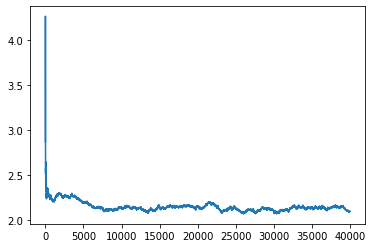

In [ ]:
btl.ewm(1000).mean().plot();

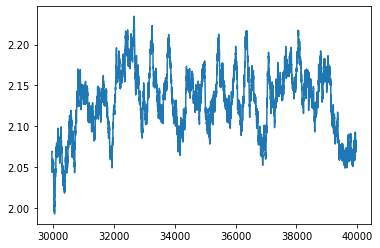

In [ ]:
btl.ewm(300).mean()[-10000:].plot();

In [ ]:
stats.iloc[-1000:].groupby('lang').mean()

,myv_mul,myv_ru,mul_myv,ru_myv
lang,,,,
ar,2.281442,1.781359,2.212551,1.958553
de,1.552813,1.619584,1.934975,1.845822
en,1.490156,1.722592,1.914080,1.821990
es,1.316202,1.324082,1.733361,1.417335
fi,1.764759,1.555346,1.916424,1.668012
fr,1.362086,1.469517,1.722820,1.518506
hi,1.673380,1.705249,2.299601,2.004956
tr,2.192849,1.457645,2.059117,1.723483
uk,1.798536,1.607200,1.714681,1.644089


The first run (without filtering; with translation in the train mode): very bad quality after some time. 

```
steps: 38000 1.6892348427948312
myv_mul    1.192329
myv_ru     0.837215
mul_myv    2.885001
ru_myv     1.842394


	myv_mul	myv_ru	mul_myv	ru_myv
lang				
ar	1.982999	0.850230	2.930305	1.312502
de	1.174256	0.890296	2.371480	1.397335
en	1.038409	0.860701	2.241457	1.306442
es	1.418636	0.847499	2.422486	1.299191
fi	1.609739	0.890430	2.705136	1.335789
fr	1.089321	0.861554	2.323156	1.301118
hi	1.565047	0.854076	2.990440	1.301399
tr	3.424027	0.910315	3.910594	1.343038
uk	1.171055	0.887820	1.928383	1.302938
zh	2.170468	0.946868	2.998269	1.348576
```

In [ ]:
stats.iloc[-1000:].groupby('src').mean()

,myv_mul,myv_ru,mul_myv,ru_myv
src,,,,
myv,1.401290,0.914682,2.494504,1.852994
ru-mul,2.131245,1.750832,1.532318,1.463202
ru-myv,1.327896,2.026147,2.350480,2.248535


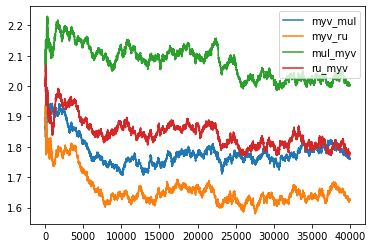

In [ ]:
stats.ewm(1000).mean()[50:].plot();

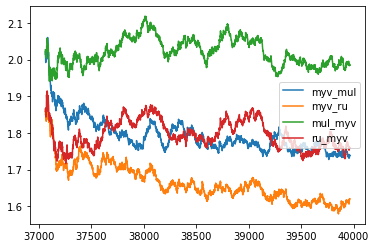

In [ ]:
stats[-3000:].ewm(300).mean()[100:].plot();

In [ ]:
myv, ru = random.choice(golden_pairs)
myv, ru

('Эрзяватнень ульнесть эрьва кодат пацят –коцтонь паця, понань паця, губовой паця, шаль.',
 'У эрзянских женщин были разнообразыне платки –суконные платки, шерстяные платки, губовые платки и шали.')

In [ ]:
for lang1, lang2 in LANGS2to3.items():
    tr = translate(
        myv, 
        model_myv_mul, tokenizer, src='myv_XX', trg=lang2, num_beams=2, do_sample=False,
        min_length=5
    )
    print(lang1)
    print(tr)

fi
Perustuslaisissa oli kaikenlaisia öitä – kutospuit, woolenpuit, suupuit, hiukkas.
de
Die Frauen des Festivals trugen verschiedene Kleidungsstücke – eine Wolltasche, eine Lippentasche, ein Schuh.
es
Las muchachas de la fiesta tenían todo tipo de trajes –cotión, Wolla, Limpia, Saal.
en
The girls of the festival wore all sorts of clothes – cotton pants, woolen pants, lipstick pants, a hat.
hi
उत्सवियों के पास हर प्रकार की गेहूं थीं-कंकौटी, woolen pants, lipstick pants, and sandals.
zh
节日的女孩们都有各种衣服 - УРНО, woolen pants, lips pants, shawls。
tr
Festivale katılan kızlar her türlü giysiyi ifa ettiler - çürütlü çorap, wovenli çorap, lipslı çorap, sol.
uk
У танцювальниць були всілякі платки - ковтонова паця, шерстиста паця, губова паця, шаль.
fr
Les filles de la fête portaient toutes sortes de vêtements - un poucheau, un poucheau de coton, un poucheau de langue, un chalure.
ar
كان للفتيات ملابس مختلفة - القمامة، القماش الخالصي، القماش губي، السل.


In [ ]:
translate(
    myv, 
    model_myv_mul, tokenizer, src='myv_XX', trg='ru_RU', num_beams=2, do_sample=True,
    min_length=5
)

'У девушек были различные платки – рубашки, шерстяные платки, губные платки, шляпы.'

In [ ]:
translate(
    ru, 
    model_mul_myv, tokenizer, src='ru_RU', trg='myv_XX', num_beams=2, do_sample=True
)

'Эрзянь аватнень ульнесть эрьва кодат пацят – суконень, понань, губань ды шалтынь.'

# Evaluate

In [ ]:
!ls /gd/MyDrive/datasets/nlp/myv_corpus/

dev1000.v1.json      myv-fi-ud-dev.json			  myv_mono.v1.json
myv-en-ud-dev.json   myv-fi-ud-test.json		  test1000.v1.json
myv-en-ud-test.json  myv_mono.v1.back_translated.v1.json  train.v1.json


In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/dev1000.v1.json', 'r') as f:
    dev = json.load(f)

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv-en-ud-dev.json', 'r') as f:
    dev_myv_en = json.load(f)
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv-fi-ud-dev.json', 'r') as f:
    dev_myv_fi = json.load(f)

len(dev_myv_en), len(dev_myv_fi)

(220, 154)

In [ ]:
model_mul_myv.eval()
model_myv_mul.eval();

In [ ]:
from sacrebleu import CHRF, BLEU
chrf_calc = CHRF(word_order=2)
bleu_calc = BLEU()

## ru -> myv

In [ ]:
dev_target = {k: [er for er, ru in v] for k, v in dev.items()}

In [ ]:
dev_translated = {k: [translate(ru, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0) for er, ru in tqdm(v)] for k, v in dev.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

ChrF++ is 50, but BLEU is only 18. 

Previous version:
```
chrF++
bible                36.45
tales                37.33
constitution         61.46
games                29.37
fiction              25.51
wiki                 50.63
41.821449810361266

BLEU
bible                9.37
tales                13.42
constitution         25.54
games                8.72
fiction              7.39
wiki                 30.55
18.728524159764728
```

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                35.99
tales                37.35
constitution         59.98
games                30.34
fiction              26.50
wiki                 50.05
41.53544835249299


In [ ]:
for k in dev:
    s = bleu_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                9.35
tales                12.28
constitution         22.17
games                9.17
fiction              7.09
wiki                 30.61
18.323800288820333


In [ ]:
for k in dev:
    print(k)
    for i in range(3):
        print(dev[k][i][0])
        print(dev[k][i][1])
        print(dev_translated[k][i])
        print()

bible
Давид инязороськак корты: «Кадык сынь понгить кундамкас каванямо шкастост! Кадык сынь прыть туворс, ды кадык сы тенст чумонь пандома!
И Давид говорит: да будет трапеза их сетью, тенетами и петлею в возмездие им;
Ды Давид мерсь: «Шнамонь кисэ! Кадык сынст ярсамось карми улеме седекс, тенецэкс ды петлейкс.

Сюкпря Пазонтень, кие кирвазтизе Титэнь седейс тынк кисэ секе жо бажамонть, кона палы минек седейсэяк!
Благодарение Богу, вложившему в сердце Титово такое усердие к вам.
Сюкпря Пазонтень, кона путсь Титонь седейс истямо покш мель тыненк.

Ансяк бути мон карман одс стявтомо сень, мезенть калавтыя икеле, сестэ теньсэ невтьса: мон – Коень каладыця.
Ибо если я снова созидаю, что разрушил, то сам себя делаю преступником.
Бути мон таго стявтосынь сень, мезенть яжинзе, сестэ эсь прянзо теян зыянонь теицякс.

tales
Вана мезе ёвтнить миненек рузонь атятне: зярдо велесь тесэ арасель, се латксонть эрясть розбойникть, эрясть землянкасо.
И вот что рассказывают наши русские старики: «Когда зд

In [ ]:
text = 'Она привязана на берегу к железобетонному столбу, врытому строителями моста десять лет назад.'
out = translate(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, do_sample=True)
print(out)
print(translate(out, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0))

Сон сюлмазь чирева кшнинь столбантень, конань строицятне вачкасть кемень иеде икеле.
Она связана с береговой железной столб, который строители заложили десять лет назад.


In [ ]:
translate(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, num_beam_groups=5, diversity_penalty=3.0, n_out=5)

/usr/local/lib/python3.7/dist-packages/transformers/generation_beam_search.py:198: UserWarning: Passing `max_length` to BeamSearchScorer is deprecated and has no effect. `max_length` should be passed directly to `beam_search(...)`, `beam_sample(...)`, or `group_beam_search(...)`.
  "Passing `max_length` to BeamSearchScorer is deprecated and has no effect. "


['Сон сюлмазь береговой кшнинь столбантень, конань стявтицятне вачкасть кемень иеде икеле.',
 'Сон сюлмазь береговой кшнинь столбантень, конань стявтицятне вачкасть кемень иеде икеле.Шнамо',
 'Сонзэ связывают лей чиресэ кшнинь столбантень, конань стявтицятне вачкасть кемень иеде икеле.',
 'Те сэдесь сюлмазь кшнинь столбантень, конань стявтицятне ульнесть кемень иеть икеле.',
 'Те сэдесь сюлмазь кшнинь столбантень, конань стявтицятне ульнесть кемень иеть икеле.Шнамо']

In [ ]:
text = 'И вот что рассказывают наши русские старики: «Когда здесь не было этого села, в этом овраге были разбойники; у них были землянки.'
out = translate(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, do_sample=True)
print(out)
print(translate(out, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0))

Ды вана мезе ёвтни минек эрзянь атятне: «Ков арасель те велесь, тосо оврагасо ульнесть розбойникть; сынст ульнесть землянкаст.
И вот что говорят наши старики: «Когда не было этого села, там в оврагах былибойники; у них были землянки.


In [ ]:
translate(text, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0, num_beam_groups=5, diversity_penalty=3.0, n_out=5)

/usr/local/lib/python3.7/dist-packages/transformers/generation_beam_search.py:198: UserWarning: Passing `max_length` to BeamSearchScorer is deprecated and has no effect. `max_length` should be passed directly to `beam_search(...)`, `beam_sample(...)`, or `group_beam_search(...)`.
  "Passing `max_length` to BeamSearchScorer is deprecated and has no effect. "


['Ды вана мезе ёвтни минек эрзянь атятне: «Зярдояк те велесэнть арасель, се овраганть ульнесть салыцят; сынст ульнесть землянкаст.',
 'Вана мезе ёвтни минек эрзянь атятне: «Зярдояк те велесэнть арасель, се овраганть ульнесть салыцят; сынст ульнесть землянкаст.',
 'Вана мезе ёвтни минек эрзянь атятне: «Зярдояк те велесэнть арасель, се овраганть ульнесть салыцят; сынст ульнесть землянкаст.Шнамо',
 'Минек эрзянь атятне истя жо кортыть: — Зярдо те велесэнть арасель, тосо ульнесть салыцят-машицятне.Шнамонь кисэ!',
 'Минек эрзянь атятне истя жо кортыть: — Зярдо те велесэнть арасель, тосо ульнесть салыцят-машицятне.']

## myv -> ru

Prev version
```
chrF++
bible                32.95
tales                30.80
constitution         54.25
games                25.08
fiction              22.80
wiki                 48.86
38.823449842762685
```

In [ ]:
dev_target_ru = {k: [ru for er, ru in v] for k, v in dev.items()}

In [ ]:
dev_translated_ru = {k: [translate(er, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0) for er, ru in tqdm(v)] for k, v in dev.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_translated_ru[k], [dev_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_translated_ru for t in dev_translated_ru[k]], 
    [[t for k in dev_target_ru for t in dev_target_ru[k]]]
).score)

bible                32.65
tales                30.59
constitution         54.18
games                24.91
fiction              22.72
wiki                 48.42
38.48251619282624


In [ ]:
for k in dev:
    s = bleu_calc.corpus_score(dev_translated_ru[k], [dev_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in dev_translated_ru for t in dev_translated_ru[k]], 
    [[t for k in dev_target_ru for t in dev_target_ru[k]]]
).score)

bible                9.95
tales                10.25
constitution         24.63
games                7.61
fiction              3.83
wiki                 32.11
19.088427504611545


In [ ]:
for k in dev:
    print(k)
    for i in range(3):
        print(dev[k][i][0])
        print(dev[k][i][1])
        print(dev_translated_ru[k][i])
        print()

bible
Давид инязороськак корты: «Кадык сынь понгить кундамкас каванямо шкастост! Кадык сынь прыть туворс, ды кадык сы тенст чумонь пандома!
И Давид говорит: да будет трапеза их сетью, тенетами и петлею в возмездие им;
Царь Давид также говорит: пусть уловятся они во время пиршества; пусть прыгают в туву, и да будет им наказание.

Сюкпря Пазонтень, кие кирвазтизе Титэнь седейс тынк кисэ секе жо бажамонть, кона палы минек седейсэяк!
Благодарение Богу, вложившему в сердце Титово такое усердие к вам.
Клянусь Богом, Который зажег для вас то же самое желание, которое и у нас в сердце!

Ансяк бути мон карман одс стявтомо сень, мезенть калавтыя икеле, сестэ теньсэ невтьса: мон – Коень каладыця.
Ибо если я снова созидаю, что разрушил, то сам себя делаю преступником.
Но если бы я возобновил то, что разрушил прежде, чтобы показать, что я продал закон.

tales
Вана мезе ёвтнить миненек рузонь атятне: зярдо велесь тесэ арасель, се латксонть эрясть розбойникть, эрясть землянкасо.
И вот что рассказываю

For ru->myv, the model often copy-pastes texts. 

For myv->ru, the model sometimes hallucinates. 

## Other languages

In [ ]:
dev_myv_en[0]

['Зярдо уш ансяк сы те шкась, кода туить Цёраксонь кирдав...',
 'If only the time would come when boys are taken away for their ordeal...']

In [ ]:
pred_en_myv = [translate(en, model_mul_myv, tokenizer, 'en_XX', 'myv_XX', num_beams=5, repetition_penalty=5.0) for myv, en in tqdm(dev_myv_en)]

  0%|          | 0/220 [00:00<?, ?it/s]

In [ ]:
pred_fi_myv = [translate(fi, model_mul_myv, tokenizer, 'fi_FI', 'myv_XX', num_beams=5, repetition_penalty=5.0) for myv, fi in tqdm(dev_myv_fi)]

  0%|          | 0/154 [00:00<?, ?it/s]

In [ ]:
pred_myv_en = [translate(myv, model_myv_mul, tokenizer, 'myv_XX', 'en_XX', num_beams=5, repetition_penalty=5.0) for myv, en in tqdm(dev_myv_en)]
pred_myv_fi = [translate(myv, model_myv_mul, tokenizer, 'myv_XX', 'fi_FI', num_beams=5, repetition_penalty=5.0) for myv, fi in tqdm(dev_myv_fi)]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

In [ ]:
print('en-myv', chrf_calc.corpus_score(pred_en_myv, [[myv for myv, en in dev_myv_en]]).score, bleu_calc.corpus_score(pred_en_myv, [[myv for myv, en in dev_myv_en]]).score)
print('fi-myv', chrf_calc.corpus_score(pred_fi_myv, [[myv for myv, fi in dev_myv_fi]]).score, bleu_calc.corpus_score(pred_fi_myv, [[myv for myv, fi in dev_myv_fi]]).score)
print('myv-en', chrf_calc.corpus_score(pred_myv_en, [[en for myv, en in dev_myv_en]]).score, bleu_calc.corpus_score(pred_myv_en, [[en for myv, en in dev_myv_en]]).score)
print('myv-fi', chrf_calc.corpus_score(pred_myv_fi, [[fi for myv, fi in dev_myv_fi]]).score, bleu_calc.corpus_score(pred_myv_fi, [[fi for myv, fi in dev_myv_fi]]).score)

en-myv 29.251991675264154 4.822525530916069
fi-myv 26.837624959806966 3.853545564511708
myv-en 26.938423017521156 6.628602568856808
myv-fi 22.016466792278568 1.9288721832340536


In [ ]:
pred_myv_en[:10]

['When is the time just to come when they are leaving their sons...',
 'No one followed the opening.',
 'All this is a threat to evil powers.',
 'But now, before the fall of the cannon, he wrapped himself in another piece of cloth, and there remained from it two other pieces of lead — «skinnuts».',
 'Meet them wherever.',
 'Inside the church are nine houses inhabited by residents of one district.',
 'The bear, I think, was given a name, but certainly not to the soldier.',
 'To the Russians, apart from herding livestock, there was another thing that did not appear — grassland had not yet been planted.',
 'If you play the violin, if you walk past the bridle of your Son, you will not die; that is said to be the understanding of a pack.',
 "After leaving Цяrdanyev's father, these actions were his — Kechayev."]

In [ ]:
dev_myv_en[:10]

[['Зярдо уш ансяк сы те шкась, кода туить Цёраксонь кирдав...',
  'If only the time would come when boys are taken away for their ordeal...'],
 ['Кенкшентькак мельганзо эзизе сёлго.',
  'She did not even close the door behind her.'],
 ['Весе те — апаро вийтнень тандавтнемс.',
  'This is all meant to scare away the evil spirits.'],
 ['Ансяк ней кандомадо икеле тапардызе лия коцт панкссо, ды эйстэнзэ чакшонь кирьгинентень кадовсть лия сэрь сулейть — «кузтеминеть».',
  'Except before carrying this one she wrapped with a different type of cloth, and different prints were left on the neck, this time it was like stairsteps.'],
 ['Аштема ков.', 'The standing moon.'],
 ['Куронть потсо ниле-вете кудот, конатнесэ эрить вейке буень ломанть.',
  'The houses were clustered in groups of four and five, and each one was the home of extended families.'],
 ['Медалесь, мон арсян, максозь лемтеме, ансяк, нама уш, а пелиця солдатнэнь.',
  'The medal, I think, was given to an anonymous, but of course courag

In [ ]:
pred_en_myv[:10]

['Бути ансяк сы шкась, зярдо цёрынетьнень саить эсест пиштемаст кисэ...',
 'Сон мельганзо кенкшентьяк эзь пекстне.',
 'Весе тень смустезэ — тандавтомс апаро оймеялтнэнь.',
 'Ансяк теде икеле сон тапардась эрьва кодамо тканьсэ, кирьгазонзо кадовсть эрьва кодат отпечаткат, те шкас ульнесь теке чалгамо тарка.',
 'Сы ковось.',
 'Кудотне ульнесть вейс теезь ниле ды вете группасо, эрьвась ульнесь келей семиянь кудокс.',
 'медальсь, арсян, максозь анонимной, но сеске жо смелстэ солдатонтень.',
 'Натой ракшатнень марто эрицятнень туртов арась лия тевесь, бути а ваномс стадаст. Ней еще аволь сея керсема шкась.',
 'Бути ушодык тей-тов налксеме, сестэ зярдояк а муят шансонь нолдамс эрзянь инициативанть. Сынь кармить кортамо: тонь ули вишка эйкакш превсэ.',
 'Зярдо тетязо тусь Циардань кис, те тевесь ульнесь сонзэ, Кечаень.']

## Round-trip translation

In [ ]:
pred_myv_en_myv = [translate(t, model_mul_myv, tokenizer, 'en_XX', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(pred_myv_en)]
pred_myv_fi_myv = [translate(t, model_mul_myv, tokenizer, 'fi_FI', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(pred_myv_fi)]
pred_en_myv_en = [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'en_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(pred_en_myv)]
pred_fi_myv_fi = [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'fi_FI', num_beams=5, repetition_penalty=5.0) for t in tqdm(pred_fi_myv)]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

In [ ]:
dev_ru_round = {k: [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0) for t in tqdm(v)] for k, v in dev_translated.items()}
dev_myv_round = {k: [translate(t, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(v)] for k, v in dev_translated_ru.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
print('en-myv-en', chrf_calc.corpus_score(pred_en_myv_en, [[en for myv, en in dev_myv_en]]).score, bleu_calc.corpus_score(pred_en_myv_en, [[en for myv, en in dev_myv_en]]).score)
print('fi-myv-fi', chrf_calc.corpus_score(pred_fi_myv_fi, [[fi for myv, fi in dev_myv_fi]]).score, bleu_calc.corpus_score(pred_fi_myv_fi, [[fi for myv, fi in dev_myv_fi]]).score)
print('myv-en-myv', chrf_calc.corpus_score(pred_myv_en_myv, [[myv for myv, en in dev_myv_en]]).score, bleu_calc.corpus_score(pred_myv_en_myv, [[myv for myv, en in dev_myv_en]]).score)
print('myv-fi-myv', chrf_calc.corpus_score(pred_myv_fi_myv, [[myv for myv, fi in dev_myv_fi]]).score, bleu_calc.corpus_score(pred_myv_fi_myv, [[myv for myv, fi in dev_myv_fi]]).score)

en-myv-en 40.550955758951154 18.194943772094994
fi-myv-fi 30.369094184845085 7.77937180025105
myv-en-myv 31.772666557859587 9.056487716097731
myv-fi-myv 27.252250152352055 5.573767872421782


In [ ]:
print(np.mean([lab[0][9:] in {'myv'} for lab in langid_model.predict(pred_en_myv)[0]]))
print(np.mean([lab[0][9:] in {'myv'} for lab in langid_model.predict(pred_fi_myv)[0]]))
print(np.mean([lab[0][9:] in {'en', 'simple'} for lab in langid_model.predict(pred_myv_en)[0]]))
print(np.mean([lab[0][9:] in {'fi'} for lab in langid_model.predict(pred_myv_fi)[0]]))

0.8772727272727273
0.9025974025974026
0.7863636363636364
0.948051948051948


In [ ]:
def lang_acc(texts, langs):
    return np.mean([lab[0][9:] in langs for lab in langid_model.predict(texts)[0]])

lang_acc(pred_en_myv, {'myv'})

0.8772727272727273

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_ru_round[k], [dev_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_ru_round for t in dev_ru_round[k]], 
    [[t for k in dev_target_ru for t in dev_target_ru[k]]]
).score)

print()

for k in dev:
    s = bleu_calc.corpus_score(dev_ru_round[k], [dev_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(bleu_calc.corpus_score(
    [t for k in dev_ru_round for t in dev_ru_round[k]], 
    [[t for k in dev_target_ru for t in dev_target_ru[k]]]
).score)

bible                40.96
tales                49.10
constitution         57.31
games                47.90
fiction              48.60
wiki                 64.45
53.058776928923976

bible                18.23
tales                27.42
constitution         27.30
games                29.98
fiction              28.67
wiki                 47.77
32.79802301266923


In [ ]:
for k in dev:
    s = lang_acc(dev_translated[k], {'myv'})
    print(f'{k:20s} {s:2.2f}')
print(lang_acc([t for k in dev_translated for t in dev_translated[k]], {'myv'}))

bible                0.98
tales                0.82
constitution         0.76
games                0.72
fiction              0.63
wiki                 0.85
0.8446666666666667


In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_myv_round[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_myv_round for t in dev_myv_round[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

print()

for k in dev:
    s = bleu_calc.corpus_score(dev_myv_round[k], [dev_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(bleu_calc.corpus_score(
    [t for k in dev_myv_round for t in dev_myv_round[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                42.37
tales                39.50
constitution         53.31
games                42.74
fiction              33.83
wiki                 55.34
47.27561875290598

bible                0.14
tales                2.04
constitution         4.35
games                2.70
fiction              1.80
wiki                 9.60
24.193981458248267


In [ ]:
for k in dev:
    s = lang_acc(dev_translated_ru[k], {'ru'})
    print(f'{k:20s} {s:2.2f}')
print(lang_acc([t for k in dev_translated_ru for t in dev_translated_ru[k]], {'ru'}))

bible                0.98
tales                0.95
constitution         0.86
games                0.84
fiction              0.78
wiki                 0.88
0.9


In [ ]:
pd.Series([lab[0][9:] for lab in langid_model.predict([t for k in dev_translated_ru for t in dev_translated_ru[k]])[0]]).value_counts().head(10)

ru     1350
alt      25
uk       19
tyv      15
ba        9
rue       9
inh       7
bg        6
myv       6
uz        5
dtype: int64

In [ ]:
pd.Series([lab[0][9:] for lab in langid_model.predict([t for k in dev_translated for t in dev_translated[k]])[0]]).value_counts().head(10)

myv          1267
ru            118
mdf            36
alt            20
udm            11
uk              7
tyv             7
bg              4
be-tarask       3
mhr             2
dtype: int64

In [ ]:
pd.Series([lab[0][9:] for lab in langid_model.predict(pred_myv_en)[0]]).value_counts().head(10)

en        170
frr         7
th          3
simple      3
bn          3
de          2
fi          2
mnw         2
az          2
sco         2
dtype: int64

In [ ]:
pd.Series([lab[0][9:] for lab in langid_model.predict(pred_en_myv)[0]]).value_counts().head(10)

myv    193
mdf     13
alt      2
cv       2
ru       2
udm      2
sah      1
bg       1
lmo      1
tyv      1
dtype: int64

In [ ]:
with open(BASE_DIR + 'dev_myv_mul_predictions.json', 'w') as f:
    json.dump({
        'en_myv': pred_en_myv,
        'fi_myv': pred_fi_myv,
        'myv_en': pred_myv_en,
        'myv_fi': pred_myv_fi,
        'en_myv_en': pred_en_myv_en,
        'fi_myv_fi': pred_fi_myv_fi,
        'myv_en_myv': pred_myv_en_myv,
        'myv_fi_myv': pred_myv_fi_myv,
        'myv_ru': dev_translated_ru,
        'ru_myv': dev_translated,
        'myv_ru_myv': dev_myv_round,
        'ru_myv_ru': dev_ru_round,
    }, f, ensure_ascii=False, indent=2)

## The test set

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/test1000.v1.json', 'r') as f:
    test_myv_ru = json.load(f)

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv-en-ud-test.json', 'r') as f:
    test_myv_en = json.load(f)
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv-fi-ud-test.json', 'r') as f:
    test_myv_fi = json.load(f)

len(test_myv_en), len(test_myv_fi)

(221, 155)

In [ ]:
test_target = {k: [er for er, ru in v] for k, v in test_myv_ru.items()}
test_translated = {k: [translate(ru, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0) for er, ru in tqdm(v)] for k, v in test_myv_ru.items()}
test_target_ru = {k: [ru for er, ru in v] for k, v in test_myv_ru.items()}
test_translated_ru = {k: [translate(er, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0) for er, ru in tqdm(v)] for k, v in test_myv_ru.items()}


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
test_pred_en_myv = [translate(en, model_mul_myv, tokenizer, 'en_XX', 'myv_XX', num_beams=5, repetition_penalty=5.0) for myv, en in tqdm(test_myv_en)]
test_pred_fi_myv = [translate(fi, model_mul_myv, tokenizer, 'fi_FI', 'myv_XX', num_beams=5, repetition_penalty=5.0) for myv, fi in tqdm(test_myv_fi)]
test_pred_myv_en = [translate(myv, model_myv_mul, tokenizer, 'myv_XX', 'en_XX', num_beams=5, repetition_penalty=5.0) for myv, en in tqdm(test_myv_en)]
test_pred_myv_fi = [translate(myv, model_myv_mul, tokenizer, 'myv_XX', 'fi_FI', num_beams=5, repetition_penalty=5.0) for myv, fi in tqdm(test_myv_fi)]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [ ]:
test_pred_myv_en_myv = [translate(t, model_mul_myv, tokenizer, 'en_XX', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(test_pred_myv_en)]
test_pred_myv_fi_myv = [translate(t, model_mul_myv, tokenizer, 'fi_FI', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(test_pred_myv_fi)]
test_pred_en_myv_en = [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'en_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(test_pred_en_myv)]
test_pred_fi_myv_fi = [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'fi_FI', num_beams=5, repetition_penalty=5.0) for t in tqdm(test_pred_fi_myv)]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [ ]:
test_ru_round = {k: [translate(t, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0) for t in tqdm(v)] for k, v in test_translated.items()}
test_myv_round = {k: [translate(t, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0) for t in tqdm(v)] for k, v in test_translated_ru.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
with open(BASE_DIR + 'test_myv_mul_predictions.json', 'w') as f:
    json.dump({
        'en_myv': test_pred_en_myv,
        'fi_myv': test_pred_fi_myv,
        'myv_en': test_pred_myv_en,
        'myv_fi': test_pred_myv_fi,
        'en_myv_en': test_pred_en_myv_en,
        'fi_myv_fi': test_pred_fi_myv_fi,
        'myv_en_myv': test_pred_myv_en_myv,
        'myv_fi_myv': test_pred_myv_fi_myv,
        'myv_ru': test_translated_ru,
        'ru_myv': test_translated,
        'myv_ru_myv': test_myv_round,
        'ru_myv_ru': test_ru_round,
    }, f, ensure_ascii=False, indent=2)

### Direct scores

In [ ]:
for k in test_myv_ru:
    s = chrf_calc.corpus_score(test_translated[k], [test_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in test_translated for t in test_translated[k]], 
    [[t for k in test_target for t in test_target[k]]]
).score)

print('\n')

for k in test_myv_ru:
    s = bleu_calc.corpus_score(test_translated[k], [test_target[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in test_translated for t in test_translated[k]], 
    [[t for k in test_target for t in test_target[k]]]
).score)

bible                36.92
tales                33.90
constitution         62.96
games                31.19
fiction              30.59
wiki                 48.56
41.16409653402746


bible                10.00
tales                7.00
constitution         27.82
games                10.33
fiction              8.68
wiki                 28.39
17.716052661184335


In [ ]:
for k in test_myv_ru:
    s = chrf_calc.corpus_score(test_translated_ru[k], [test_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in test_translated_ru for t in test_translated_ru[k]], 
    [[t for k in test_target_ru for t in test_target_ru[k]]]
).score)

print('\n')

for k in test_myv_ru:
    s = bleu_calc.corpus_score(test_translated_ru[k], [test_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in test_translated_ru for t in test_translated_ru[k]], 
    [[t for k in test_target_ru for t in test_target_ru[k]]]
).score)

bible                33.55
tales                28.42
constitution         60.60
games                26.57
fiction              26.60
wiki                 47.55
38.633402079862265


bible                10.71
tales                7.30
constitution         33.31
games                9.85
fiction              5.95
wiki                 32.24
19.683741739128525


In [ ]:
print('en-myv', chrf_calc.corpus_score(test_pred_en_myv, [[myv for myv, en in test_myv_en]]).score, bleu_calc.corpus_score(test_pred_en_myv, [[myv for myv, en in test_myv_en]]).score)
print('fi-myv', chrf_calc.corpus_score(test_pred_fi_myv, [[myv for myv, fi in test_myv_fi]]).score, bleu_calc.corpus_score(test_pred_fi_myv, [[myv for myv, fi in test_myv_fi]]).score)
print('myv-en', chrf_calc.corpus_score(test_pred_myv_en, [[en for myv, en in test_myv_en]]).score, bleu_calc.corpus_score(test_pred_myv_en, [[en for myv, en in test_myv_en]]).score)
print('myv-fi', chrf_calc.corpus_score(test_pred_myv_fi, [[fi for myv, fi in test_myv_fi]]).score, bleu_calc.corpus_score(test_pred_myv_fi, [[fi for myv, fi in test_myv_fi]]).score)

en-myv 28.031704657986722 2.777013966013641
fi-myv 27.42669535161251 4.797349745559699
myv-en 25.99402014228913 5.4420526366119155
myv-fi 22.34623223113071 3.0268291375922307


### Round-trip scores

In [ ]:
print('en-myv-en', chrf_calc.corpus_score(test_pred_en_myv_en, [[en for myv, en in test_myv_en]]).score, bleu_calc.corpus_score(test_pred_en_myv_en, [[en for myv, en in test_myv_en]]).score)
print('fi-myv-fi', chrf_calc.corpus_score(test_pred_fi_myv_fi, [[fi for myv, fi in test_myv_fi]]).score, bleu_calc.corpus_score(test_pred_fi_myv_fi, [[fi for myv, fi in test_myv_fi]]).score)
print('myv-en-myv', chrf_calc.corpus_score(test_pred_myv_en_myv, [[myv for myv, en in test_myv_en]]).score, bleu_calc.corpus_score(test_pred_myv_en_myv, [[myv for myv, en in test_myv_en]]).score)
print('myv-fi-myv', chrf_calc.corpus_score(test_pred_myv_fi_myv, [[myv for myv, fi in test_myv_fi]]).score, bleu_calc.corpus_score(test_pred_myv_fi_myv, [[myv for myv, fi in test_myv_fi]]).score)

en-myv-en 41.03388181537263 18.181372444998697
fi-myv-fi 30.377467107652826 7.10782701497502
myv-en-myv 31.198652189856773 7.572821826138965
myv-fi-myv 28.21878237612825 6.714786271034701


In [ ]:
print(np.mean([lab[0][9:] in {'myv'} for lab in langid_model.predict(test_pred_en_myv)[0]]))
print(np.mean([lab[0][9:] in {'myv'} for lab in langid_model.predict(test_pred_fi_myv)[0]]))
print(np.mean([lab[0][9:] in {'en', 'simple'} for lab in langid_model.predict(test_pred_myv_en)[0]]))
print(np.mean([lab[0][9:] in {'fi'} for lab in langid_model.predict(test_pred_myv_fi)[0]]))

0.8914027149321267
0.8903225806451613
0.8235294117647058
0.9419354838709677


In [ ]:
def rtt_langid_chrf(texts, intermediate, rtt, target_langs, langid_model, calc):
    targets = []
    translations = []
    lang_correct = [lab[0][9:] in target_langs for lab in langid_model.predict(intermediate)[0]]
    for gt, pred, correctness in zip(texts, rtt, lang_correct):
        if correctness:
            targets.append(gt)
            translations.append(pred)
    forall = calc.corpus_score(rtt, [texts]).score
    loose = calc.corpus_score(translations, [targets]).score
    proportion = np.mean(lang_correct)
    return forall, loose, proportion, proportion * loose

print('en-myv-en', *rtt_langid_chrf([en for myv, en in test_myv_en], test_pred_en_myv, test_pred_en_myv_en, {'myv'}, langid_model, chrf_calc))
print('fi-myv-fi', *rtt_langid_chrf([fi for myv, fi in test_myv_fi], test_pred_fi_myv, test_pred_fi_myv_fi, {'myv'}, langid_model, chrf_calc))
print('myv-en-myv', *rtt_langid_chrf([myv for myv, en in test_myv_en], test_pred_myv_en, test_pred_myv_en_myv, {'en', 'simple'}, langid_model, chrf_calc))
print('myv-fi-myv', *rtt_langid_chrf([myv for myv, fi in test_myv_fi], test_pred_myv_fi, test_pred_myv_fi_myv, {'fi'}, langid_model, chrf_calc))

en-myv-en 41.03388181537263 40.6934673828438 0.8914027149321267 36.27426730506891
fi-myv-fi 30.377467107652826 30.36386236037933 0.8903225806451613 27.033632295047404
myv-en-myv 31.198652189856773 31.485059272913485 0.8235294117647058 25.92887234239934
myv-fi-myv 28.21878237612825 28.165309697388803 0.9419354838709677 26.529904618185583


ru-myv-ru

In [ ]:
for k in test_myv_ru:
    s = chrf_calc.corpus_score(test_ru_round[k], [test_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in test_ru_round for t in test_ru_round[k]], 
    [[t for k in test_target_ru for t in test_target_ru[k]]]
).score)

print()

for k in test_myv_ru:
    s = bleu_calc.corpus_score(test_ru_round[k], [test_target_ru[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(bleu_calc.corpus_score(
    [t for k in test_ru_round for t in test_ru_round[k]], 
    [[t for k in test_target_ru for t in test_target_ru[k]]]
).score)

bible                42.53
tales                50.88
constitution         64.70
games                48.44
fiction              49.48
wiki                 64.00
53.74029384610477

bible                19.30
tales                28.76
constitution         38.41
games                32.40
fiction              26.87
wiki                 47.62
33.77346226507662


In [ ]:
for k in test_myv_ru:
    s = lang_acc(test_translated[k], {'myv'})
    print(f'{k:20s} {s:2.2f}')
print(lang_acc([t for k in test_translated for t in test_translated[k]], {'myv'}))

bible                0.99
tales                0.77
constitution         0.64
games                0.70
fiction              0.57
wiki                 0.84
0.828


myv-ru-myv

In [ ]:
for k in test_myv_ru:
    s = chrf_calc.corpus_score(test_myv_round[k], [test_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in test_myv_round for t in test_myv_round[k]], 
    [[t for k in test_target for t in test_target[k]]]
).score)

print()

for k in test_myv_ru:
    s = bleu_calc.corpus_score(test_myv_round[k], [test_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(bleu_calc.corpus_score(
    [t for k in test_myv_round for t in test_myv_round[k]], 
    [[t for k in test_target for t in test_target[k]]]
).score)

bible                42.34
tales                39.28
constitution         55.89
games                44.61
fiction              39.91
wiki                 55.55
47.8390640341326

bible                15.37
tales                14.85
constitution         19.37
games                24.89
fiction              17.26
wiki                 36.34
24.877923948045478


In [ ]:
for k in test_myv_ru:
    s = lang_acc(test_translated_ru[k], {'ru'})
    print(f'{k:20s} {s:2.2f}')
print(lang_acc([t for k in test_translated_ru for t in test_translated_ru[k]], {'ru'}))

bible                0.99
tales                0.91
constitution         0.90
games                0.85
fiction              0.83
wiki                 0.90
0.91


In [ ]:
print('ru-myv-ru', *rtt_langid_chrf(
    [t for p in test_target_ru.values() for t in p], 
    [t for p in test_translated.values() for t in p], 
    [t for p in test_ru_round.values() for t in p], 
    {'myv'}, langid_model, chrf_calc)
)

ru-myv-ru 53.74029384610477 51.02868983225566 0.828 42.25175518110768


In [ ]:
print('myv-ru-myv', *rtt_langid_chrf(
    [t for p in test_target.values() for t in p], 
    [t for p in test_translated_ru.values() for t in p], 
    [t for p in test_myv_round.values() for t in p], 
    {'ru'}, langid_model, chrf_calc)
)

myv-ru-myv 47.8390640341326 47.31164732127339 0.91 43.053599062358785


# Other stuff

In [ ]:
sorted(LANGS2)

['ar', 'de', 'en', 'es', 'fi', 'fr', 'hi', 'tr', 'uk', 'zh']

In [ ]:
for t in ['один', 'два', 'три', 'пять', 'десять', 'семнадцать', 'пятьдесят девять', 'восемьдесят шесть', 'сто тридцать два', 'двести пятнадцать', 'восемьсот', 'тысяча', 'миллион']:
    t2 = translate(t, model_mul_myv, tokenizer, 'ru_RU', 'myv_XX', num_beams=5, repetition_penalty=5.0)
    t3 = translate(t2, model_myv_mul, tokenizer, 'myv_XX', 'ru_RU', num_beams=5, repetition_penalty=5.0)
    print(t, '->', t2, '->', t3)

один -> ськамонзо -> одинокий
два -> кавто -> двое
три -> колмо -> три
пять -> вете -> пять
десять -> кемень -> десять
семнадцать -> семнадцать -> семнадцать
пятьдесят девять -> ведьгемень вейксэ -> девятьдесят пять
восемьдесят шесть -> кавксогемень кодгемень -> восемьдесят шесть
сто тридцать два -> сядовейксэе -> семьдесят два
двести пятнадцать -> кавтосядт ведьгемень -> двести пятьдесят
восемьсот -> кавксосядт -> восемьсот
тысяча -> тыща -> тысяча
миллион -> миллионт -> миллионный
